# The Extract Transform and Load (ETL) procedure


This notebook will walk you through the process that loads the data from a FITS cube into the Parquet tables on a Hive enabled HDFS cluster. 

## Part 1 Create and save the Sparkfits dataframe

This notebook reads the local FITS file and creates a spark-fits ataframe that has been properly partitioned to maintain the correct order of the data.

This notebook runs Spark in local mode in order to read the local file; this is necessary because to load the file in YARN-CLIENT of YARN_CUSTER mode, the file needs to be copied to the working directory on each worker node. Untenable on an 800+ GB FITS file and on a multi workler cluster.

There needs to be enough free disk space available on the spark.local.dir as well.

### NOTE!

You must use spark-fits version 0.9.0 or higher to properly partitin the dataframe.


In [1]:
conf = SparkConf().setAll([('spark.executor.memory', '8g'),\
                           ('spark.driver.memory', '6g'),\
                           ('spark.shuffle.service.enabled', True), \
                           ('spark.sql.shuffle.partitions', 144), \
                           ('spark.default.parallelism', 144),\
                           ('spark.dynamicAllocation.enabled', True), \
                           ('spark.dynamicAllocation.executorIdleTimeout', 600), \
                           ('spark.executor.cores', 4),\
                           ('spark.executor.instances', 40), \
                           ('spark.local.dir','/mnt/FITs/Spark/tmp,/mnt1/FITs/Spark/tmp,/mnt2/FITs/Spark/tmp'),\
                           ('spark.jars.packages', 'com.github.astrolabsoftware:spark-fits_2.11:0.9.0'),\
                           ('spark.executor.memoryOverhead', '6g'),\
                           ('spark.driver.memoryOverhead', '4g'),\
                           ('spark.rpc.message.maxSize', '512'),\
                           ('spark.scheduler.mode', 'FAIR'),\
                           ('spark.kryoserializer.buffer.max', '1g'),\
                           ('spark.hadoop.hive.exec.dynamic.partition', True), \
                           ('spark.hadoop.hive.exec.dynamic.partition.mode','nonstrict'), \
                           ('spark.hadoop.hive.exec.max.dynamic.partitions', 100000), \
                           ('spark.hadoop.hive.exec.max.dynamic.partitions.pernode', 100000), \
                           ('spark.app.name','Fits on HDFS')])

    # Stop the old context spark.driver.allowMultipleContexts = true
    #sc.stop()

    # And restart the context with the new configuration
    #sc = SparkContext(conf=conf)
    #sqlContext = SQLContext(sc)

In [2]:
if False:
    conf.setMaster("local[*]")
    sc.stop()
    spark.stop()
    SparkSession._instantiatedContext = None
    #sc._instantiatedContext = None
    sc=SparkContext(conf=conf)
    spark=SparkSession(sc)

In [3]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [4]:
spark

In [5]:
# ====================================================
# Library import
# ====================================================
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
plt.style.use(astropy_mpl_style)

## Let's run a simple object finder on our image,
## and collect the catalog.
import numpy as np
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

from scipy import sparse
from scipy.sparse import csr_matrix

from random import randint
from time import sleep

from spectral_cube import SpectralCube
from astroquery.esasky import ESASky
from astroquery.utils import TableList
from reproject import reproject_interp
import astropy.units as u

from pyspark.sql import SQLContext, SparkSession, HiveContext
from pyspark import StorageLevel

from pyspark import SparkFiles

from pyspark.sql import functions as F
import pyspark.sql.functions as f

from pyspark.sql.functions import randn, monotonically_increasing_id, row_number, desc, udf, col, lit
from pyspark.sql.functions import broadcast
from pyspark.sql.types import ArrayType, FloatType,IntegerType, DataType, DoubleType,Row, BooleanType

"""
Set the Spark datatypes
"""
iType=IntegerType()
dType=DoubleType()
fType=FloatType()

from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql.window import Window

from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import SparseVector, DenseVector,VectorUDT

from datetime import datetime
import time
import logging
import sys
import subprocess



maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/cache


In [6]:
from time import time, clock
class Timer:
    """
    a simple class for printing time (s) since last call
    """
    def __init__(self):
        self.t0=time()
        self.t1=clock()
        self.elapsed = 1
        self.elapsedCPU = 1
    
    def start(self):
        self.t0=time()
        self.t1=clock()
        
    def stop(self):
        t1=time()
        t2=clock()
        print("Elapsed {:2.1f}s, CPU {:2.1f}s".format(t1-self.t0, t2-self.t1))
        self.elapsed = t1-self.t0
        self.elapsedCPU = t2-self.t1

class DataframeError(Exception): 
  
    # Constructor or Initializer 
    def __init__(self, value): 
        self.value = value 
  
    # __str__ is to print() the value 
    def __str__(self): 
        return(repr(self.value)) 

In [7]:
def calculateBand(x, bandCount=32):
    x = x  // bandCount
    return x


In [8]:
GetBandUDF = udf(lambda arr, bw: calculateBand(np.int(arr), bw), iType)

In [9]:
from pyspark.sql.types import ArrayType, FloatType,IntegerType, DataType, DoubleType,Row, BooleanType

"""
Set the Spark datatypes
"""
iType=IntegerType()
dType=DoubleType()
fType=FloatType()

In [10]:
FileName='image.restored.i.SB2338.V2.cube.fits'
localFile='file:///mnt1/FITs/' + FileName
hdfsFilePath='hdfs:///user/hduser/FITS_Files/image.restored.i.SB2338.V2.cube.fits' #+FileName

In [11]:
hdu=0

In [12]:
hdfsFilePath

'hdfs:///user/hduser/FITS_Files/image.restored.i.SB2338.V2.cube.fits'

In [13]:
df = sqlContext.read.format("fits").option("hdu", hdu).load(localFile)

### Repartition the spark-fits dataframe

This maintains the proper order in the file when we save it to HDFS. See

https://github.com/astrolabsoftware/spark-fits/issues/91

In [20]:
df_repartitioned = df.repartition('ImgIndex')

### And write the dataframe to parquet

In this example, we rename the file "filename.fits" to "filename2.parquet"

First, check if the file already exists and delete it if it does

In [16]:
targetFile=hdfsFilePath.replace('.fits', '2.parquet')

In [21]:
timer.start()

pathExists=subprocess.call(["hdfs", "dfs", "-ls", targetFile ])
if pathExists==0:
    print("Target file exists {}, deleting...".format( targetFile ))
    subprocess.call(["hdfs", "dfs", "-rm", "-r", targetFile])

print("Saving spark-fits dataframe to Parquet")
df_repartitioned.write.parquet(targetFile, compression='none')
print("Dataframe saved to parquet!")

timer.stop()

Saving spark-fits dataframe to Parquet


### Test the file

We'll take one channel and plot it

In [14]:
df_parquet = spark.read.format('parquet').load( targetFile )

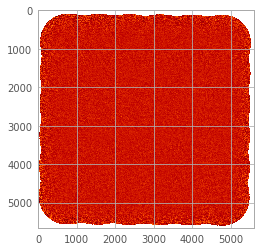

In [15]:
channel2=df_parquet.take(5654)
channel2 = [i[0] for i in channel2]
plt.imshow(channel2)

### Staging table loaded to Parquet and tested

the Part 2 notebook describes 

* how we add the declination indexes and loads the fits dataframe into the final partitioned Parquet table
* the dimension extraction routines 
    * Spectra (frequency or velocity)
    * Position (Right ascension, declination)